In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary
chars = sorted(list(set(''.join(words))))
s2i = {s:i+1 for i, s in enumerate(chars)}  # 一定别忘i+1，因为'.'是0
s2i['.'] = 0
i2s = {i:s for s, i in s2i.items()}
print(i2s)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [64]:
# build the dataset

block_size = 3
X, Y = [], []
for w in words:

    # print(w)
    context = [0] * block_size
    for char in w + '.':
        ix = s2i[char]
        X.append(context)
        Y.append(ix)
        # print(''.join([i2s[i] for i in context]), '--->', i2s[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [65]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

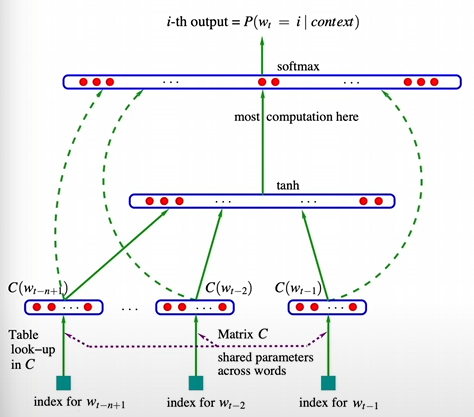

In [8]:
C = torch.randn((27, 2))  # 构建词表

In [9]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [10]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [26]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h

tensor([[ 0.4775,  0.1422, -0.9999,  ..., -0.1649,  1.0000, -0.7275],
        [-0.7828, -0.1110, -0.9866,  ..., -0.9264,  0.9996, -0.9273],
        [ 0.3500, -0.9838, -0.9909,  ...,  0.0474,  0.9999, -0.9862],
        ...,
        [-0.1838, -0.5616, -0.9598,  ...,  0.3626,  0.9284,  0.9984],
        [ 0.1628, -0.9696, -0.6788,  ...,  0.8308,  0.9645,  0.9427],
        [ 0.7325,  0.1359, -0.9971,  ...,  0.9375,  0.9978,  0.9997]])

In [27]:
h.shape

torch.Size([32, 100])

In [28]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [30]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [31]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)
prob.shape

torch.Size([32, 27])

### 拿出标签(Y)对应的概率

In [33]:
prob[torch.arange(32), Y]

tensor([2.3497e-11, 7.6850e-09, 9.2693e-14, 7.2822e-07, 3.3149e-12, 2.1387e-11,
        1.4723e-01, 2.3596e-03, 4.9294e-07, 6.0167e-07, 3.2815e-10, 3.1571e-10,
        3.8717e-13, 4.5254e-09, 2.4475e-07, 1.8803e-13, 9.3404e-01, 1.5762e-08,
        7.3780e-06, 6.8969e-12, 3.1490e-08, 2.5042e-01, 2.2103e-08, 2.2288e-08,
        7.9989e-21, 9.5873e-10, 3.1094e-15, 2.5851e-04, 3.4788e-08, 2.3394e-01,
        3.3308e-16, 2.1389e-15])

In [34]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(19.2922)

### 整理一下

In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):   
    X, Y = [], []
    for w in words:

        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = s2i[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
Xtr.shape, Ytr.shape  # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [7]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [8]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [9]:
for p in parameters:
    p.requires_grad = True

### 训练

In [10]:
for i in range(200000):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]]  # (32, 3, 10)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item()) 

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

### 验证

In [11]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1246, grad_fn=<NllLossBackward0>)

In [12]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1730, grad_fn=<NllLossBackward0>)

## 采样

In [13]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 5)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(i2s[i] for i in out))

cari.
dyming.
codmelia.
adiaisors.
shibi.
rzina.
gres.
den.
tun.
aswaily.
malei.
cera.
ryennixxeed.
dilleigh.
auna.
ranlynn.
jabbi.
tya.
broalian.
abick.
